In [59]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import scipy.signal
import logging
import time

from lisagwresponse import GalacticBinary
from lisainstrument import Instrument

from pytdi import Data
from pytdi import michelson as mich
from pytdi import ortho

from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn

In [77]:
# orbit_path = '../orbits/keplerianupsampled.h5'
# orbit_path = '../orbits/kep-1hz30d.h5'
orbit_path = '../orbits/keplerian_long.h5'
gw_path = 'test.h5'

# Setup simluation parameters
fs = .1 # Hz
day = 86400 # s
duration = day # X days
size = duration*fs
discard = 300

rec = ['A','E','T']

with h5py.File(orbit_path) as orbits:
    orbits_t0 = orbits.attrs['t0']
    orbit_fs = 1/orbits.attrs['dt']
    orbit_dur = orbits.attrs['tsize']/orbit_fs
    print ("fs = "+str(fs)+" Hz,  orbit_duration = "+str(orbit_dur/day)+" d")


# True values of inserted parameters
Amp_true = [1e-16,5e-13]
f_true = [1e-3,1e-4]
phi0_true = [0,0]

fs = 0.1 Hz,  orbit_duration = 1500.0 d


In [78]:
# Setup galactic binary to insert in simulation
!rm test.h5

for a,f,p in zip(Amp_true,f_true,phi0_true):
    source = GalacticBinary(A=a, f=f, phi0=p, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
# source = GalacticBinary(A=Amp_true, f=f_true, phi0=phi0_true, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
#source = GalacticBinary(A=6.4e-23, f=6.22e-3, orbits=orbit_path, t0=orbits_t0+10, gw_beta=0,gw_lambda=0) #HM Cnc
#source = GalacticBinary(A=5E-20, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0)
#source = GalacticBinary(A=1E-16, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0) #ridiculously loud binary

    source.write("test.h5")

In [79]:
sample_instru = Instrument(
    size=size, # in samples
    dt=1/fs,
    aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
    orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
    gws=gw_path
)
sample_instru.disable_all_noises()
sample_instru.simulate()

In [80]:
# Import data in two ways
rawdata = Data.from_instrument(sample_instru)

# Build A chanel
t0 = time.time()
A = ortho.A2.build(**rawdata.args)(rawdata.measurements)[discard:]
t1 = time.time()
print ("Time to build and run A2 = "+str(t1-t0))

t = sample_instru.t[discard:]
#t = (np.arange(0,len(A)+discard)/fs)[discard:]

sdata = np.array([t,A])

Time to build and run A2 = 2.3582301139831543


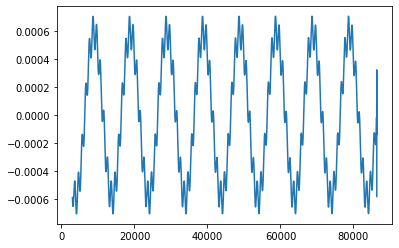

(2, 8340)


In [81]:
plt.plot(t,A)
plt.show()
print (sdata.shape)

In [82]:
# Create psd for data
def psd_func(data):
    return scipy.signal.welch(data,fs=fs,window='nuttall',nperseg=len(data),detrend=False)

# Make psd of unfiltered data
psd = psd_func(sdata[1])

# Create filtered data
cutoff = 100
coeffs = scipy.signal.firls(73, bands=[0,2e-2,3e-2,fs/2], desired=[1,1,0,0],fs=fs)
fsdata = np.array([sdata[0][cutoff:-cutoff],scipy.signal.filtfilt(coeffs,1., x=sdata[1],padlen=len(psd[0]))[cutoff:-cutoff]])

# Make psd of filtered data
fpsd = psd_func(fsdata[1])

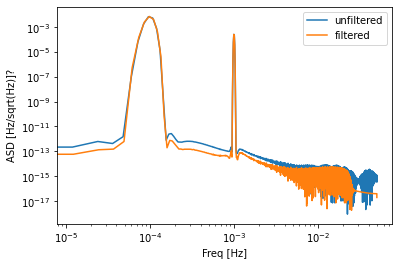

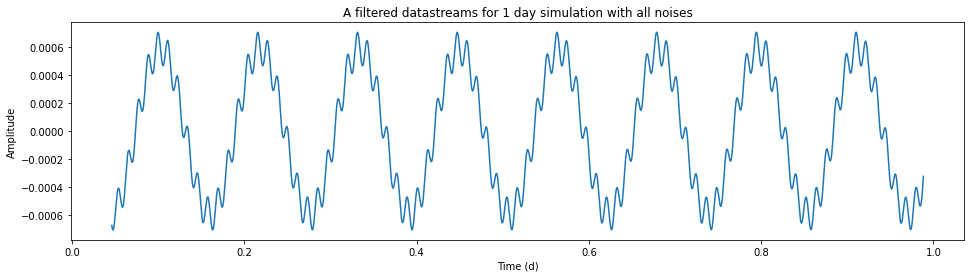

In [83]:
plt.plot(psd[0],psd[1], label='unfiltered')
plt.plot(fpsd[0],fpsd[1], label='filtered')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('ASD [Hz/sqrt(Hz)]?')
plt.legend()
plt.show()


plt.figure(figsize=(16,4))
plt.plot(fsdata[0]/day,fsdata[1])
plt.title('A filtered datastreams for 1 day simulation with all noises')
plt.xlabel('Time (d)')
plt.ylabel('Amplitude')
#plt.xlim(.25,.30)
plt.show()



In [84]:
# Generate random binary to be able to build the TDI chanels
time_elapsed = []
time_elapsed.append(time.time())

# GalBin = GalacticBinary(A=1, f=1e-3, orbits=orbit_path ,t0=orbits_t0+10, gw_beta=0, gw_lambda=0,dt=1/fs,size=size+300)
for a,f,p in zip(Amp_true,f_true,phi0_true):
    # GalBin = GalacticBinary(A=a, f=f, phi0=p, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
    GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
    GalBin.write('test2.h5')

# GalBin = GalacticBinary(A=Amp_true, f=f_true, phi0=phi0_true, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
# GalBin.write('test2.h5')
rawdata = Data.from_gws('test2.h5',orbit_path,interpolate=True)
# rawdata = Data.from_gws('test.h5',orbit_path)


time_elapsed.append(time.time())

Afunc = ortho.A2.build(**rawdata.args)
time_elapsed.append(time.time())
A = Afunc(rawdata.measurements)[discard:]
time_elapsed.append(time.time())

print ("gw = {:.2f}, TDIbuild = {:.2f}, TDIcalc = {:.2f}, Total = {:.2f}".format(time_elapsed[1]-time_elapsed[0],\
        time_elapsed[2]-time_elapsed[1], time_elapsed[3]-time_elapsed[2], time_elapsed[3]-time_elapsed[0]))


# t = source.t[discard:]
t = GalBin.t[discard:]
# t = model_instru.t[discard:]
# t = (np.arange(0,len(A)+discard)/4)[discard:]
mdata = np.array([t,A])

# #
# sample_instru = Instrument(
#     size=size, # in samples
#     dt=1/fs,
#     aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
#     orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
#     gws=gw_path
# )
# sample_instru.simulate()





!rm test2.h5

gw = 0.18, TDIbuild = 0.59, TDIcalc = 0.02, Total = 0.80


# Factor difference between pytdi.Data.from_instrument and pytdi.Data.from_gws
### From instrument returns amplitude $\frac{d\nu}{\nu}$ where $\nu$ is the laser frequency, while gws returns $h=\frac{dL}{L}=\frac{d\phi}{\phi}$.

### We know $\phi = \omega t = 2\pi \nu t$, so $\dot\phi = 2\pi \nu$, $\Delta\nu = \frac{1}{2\pi}\dot{\Delta\phi}$

### $\frac{\Delta\nu}{\nu} = \frac{1}{2\pi \nu_{laz}} \frac{d}{dt}[\frac{\Delta \phi}{\phi}] = \frac{1}{2\pi \nu_{laz}} \frac{d[\Delta \phi/ \phi]}{f_{gw}\Delta t}$

### However, this did not work since $\frac{\Delta\nu}{\nu} \sim 10^{-3}, \frac{\Delta \phi}{\phi} \sim 10^{-18}$ and $\nu_{laz} \sim 10^{14}$ so instead we multiply by $\nu_{laz}$ which gives

### $\frac{\Delta\nu}{\nu} = \frac{\nu_{laz}}{2\pi } \frac{d[\Delta \phi/ \phi]}{f_{gw}\Delta t} $


# For 2 gws this needs to be expanded
### $\phi = (\omega_1 + \omega_2) t = 2\pi (\nu_1 + \nu_2) t$, so $\dot\phi = 2\pi (\nu_1 + \nu_2)$, $\Delta\nu = \frac{1}{2\pi}\dot{\Delta\phi}$

## $\frac{\Delta \nu_{tot}}{\nu} = \frac{\Delta \nu_1}{\nu_1} + \frac{\Delta \nu_2}{\nu_2},$ We know that $\nu_1 = \nu_2$ and $\Delta \nu_1 \neq \Delta \nu_2$.

## $\frac{\Delta\nu_1 + \Delta\nu_2}{\nu} = \frac{\nu_{laz}}{2\pi \Delta t} \Big[ \frac{d[\Delta \phi_1/ \phi_1]}{f_{gw,1}} + \frac{d[\Delta \phi_2/ \phi_2]}{f_{gw,2}} \Big]$


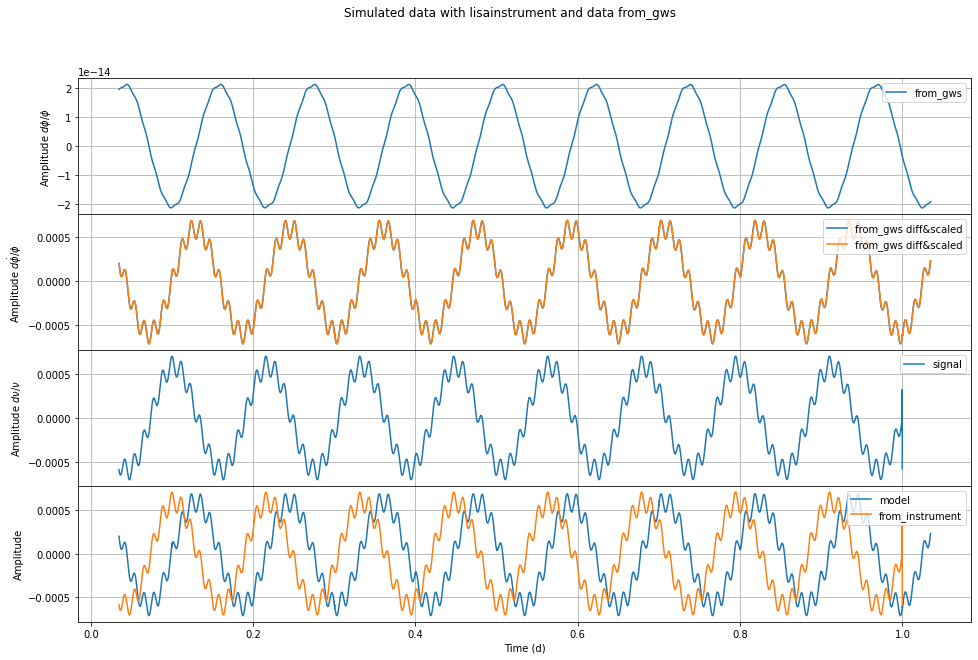

Percentage difference between two amplitudes = 2.650%


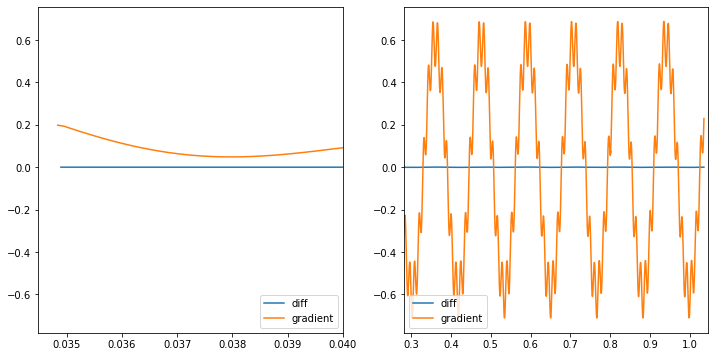

In [85]:
# Cell to get the different factor between Data.from_instrument and Data.from_gws right
gw_unit = f_true[0] #(f_true[0]*f_true[1])/np.sum(f_true)
# Laser wl = 1064nm https://www.worldscientific.com/doi/abs/10.1142/S0218271818450025
# dnu/nu = d(phi_dot)/nu = d(phi_dot)*wl/c and maybe times (2pi)^x where x is some value
# Order of 10^16
def dphi_to_dnu(data,dt=1/fs, f_gw = gw_unit):
    laser_freq = 2.816E14 #Hz, gotten from lisainstrument code
    # dt = np.mean((time[1:]-time[:-1]))
    # return np.diff(data) * ((laser_freq) / (2*np.pi*f_gw*dt))
    return np.diff(data) * ((laser_freq) / (2*np.pi*dt))


tmpx = mdata[0]#[cutoff:-cutoff]
tmpy = mdata[1]#[cutoff:-cutoff]
ntmpy = dphi_to_dnu(tmpy)


fig, axs = plt.subplots(4, sharex=True, gridspec_kw={'hspace': 0},figsize=(16,10))
fig.set_figheight(10)
fig.set_figwidth(16)
fig.suptitle("Simulated data with lisainstrument and data from_gws")
axs[0].plot(tmpx/day,tmpy,label='from_gws')
axs[0].set_ylabel('Amplitude $d\phi/\phi$')
axs[0].legend(loc=1)
axs[0].grid()
axs[1].plot(tmpx[:-1]/day,ntmpy,label='from_gws diff&scaled')
axs[1].plot((tmpx[1:]/day),ntmpy,label='from_gws diff&scaled')
axs[1].set_ylabel('Amplitude $d\dot{\phi}/\phi$')
axs[1].legend(loc=1)
axs[1].grid()
axs[2].plot(sdata[0]/day,sdata[1],label='signal')
axs[2].set_ylabel('Amplitude $d\\nu/\\nu$')
axs[2].legend(loc=1)
axs[2].grid()
axs[3].plot((tmpx[:-1]/day),ntmpy,label='model')
axs[3].plot(sdata[0]/day,sdata[1],label='from_instrument')
axs[3].set_ylabel('Amplitude')
axs[3].set_xlabel('Time (d)')
axs[3].legend(loc=1)
axs[3].grid()
plt.show()

pc = (np.max(sdata[1])-np.max(ntmpy))/np.max(ntmpy)*100
print ("Percentage difference between two amplitudes = {:.3f}%".format(pc))


def dphi_to_dnu_gradient(data,dt=1/fs, f_gw = gw_unit):
    laser_freq = 2.816E14 #Hz, gotten from lisainstrument code
    # dt = np.mean((time[1:]-time[:-1]))
    return np.gradient(data) * ((laser_freq) / (2*np.pi*f_gw*dt))

fig,axs = plt.subplots(1,2, figsize=(12,6))
axs[0].plot(((tmpx[1:]+tmpx[:-1])/(2*day)),ntmpy,label='diff')
axs[0].plot(tmpx/day,dphi_to_dnu_gradient(tmpy),label='gradient')
axs[0].set_xlim(0.99*np.min(tmpx)/day,0.04)
# axs[0].set_ylim([-6e-5,-3e-6])
axs[0].legend(loc=4)
axs[1].plot(((tmpx[1:]+tmpx[:-1])/(2*day)),ntmpy,label='diff')
axs[1].plot(tmpx/day,dphi_to_dnu_gradient(tmpy),label='gradient')
axs[1].set_xlim(0.282,1.01*np.max(tmpx)/day)
# axs[1].set_ylim([0,1e-3])
axs[1].legend(loc=3)
plt.show()


## Make multi dimentional gauss possible

/tmp/ipykernel_3359/2577700453.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(gauss)#/(np.sqrt(2*np.pi*(sig)**2))) so gaussian is not normalised so peak is at 1 (log peak at 0)
/tmp/ipykernel_3359/2577700453.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(gauss)#/(np.sqrt(2*np.pi*(sig)**2))) so gaussian is not normalised so peak is at 1 (log peak at 0)


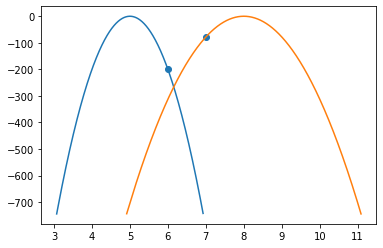

In [104]:
# Coding gaussian prior
def gauss_prior(arr, sig, mu):
    gauss = np.exp(-((arr-mu)**2)/(2*(sig**2)))
    return np.log(gauss)#/(np.sqrt(2*np.pi*(sig)**2))) so gaussian is not normalised so peak is at 1 (log peak at 0)

x = np.linspace(-20,20,10000)

mu = np.array([5,8])
s = 0.01*mu

plt.plot(x,gauss_prior(x,s[0],mu[0]))
plt.plot(x,gauss_prior(x,s[1],mu[1]))

plt.scatter([6,7],gauss_prior([6,7],s,mu))

plt.show()

# Amplitude-frequency relation after TDI

In [83]:
# GalBin = GalacticBinary(A=1, f=1e-3, orbits=orbit_path ,t0=orbits_t0+10, gw_beta=0, gw_lambda=0,dt=1/fs,size=size+300)
a = 0.01 #2.8e-4
f = 5e-4 # Hz
p = np.pi*.6 #rad

print ("True values for theta = [{},{},{}]".format(a,f,p))

GalBin = GalacticBinary(A=a, f=f, phi0=p, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
GalBin.write('test2.h5')
rawdata = Data.from_gws('test2.h5',orbit_path)

time_elapsed.append(time.time())

Afunc = ortho.A2.build(**rawdata.args)
time_elapsed.append(time.time())
A = Afunc(rawdata.measurements)[discard:]
time_elapsed.append(time.time())

print ("gw = {:.2f}, TDIbuild = {:.2f}, TDIcalc = {:.2f}, Total = {:.2f}".format(time_elapsed[1]-time_elapsed[0],\
        time_elapsed[2]-time_elapsed[1], time_elapsed[3]-time_elapsed[2], time_elapsed[3]-time_elapsed[0]))

t = GalBin.t[discard:]
# t = model_instru.t[discard:]
# t = (np.arange(0,len(A)+discard)/4)[discard:]
mdata = np.array([t,A])
!rm test2.h5

True values for theta = [0.01,0.0005,1.8849555921538759]
gw = 0.19, TDIbuild = 0.57, TDIcalc = 0.02, Total = 0.78


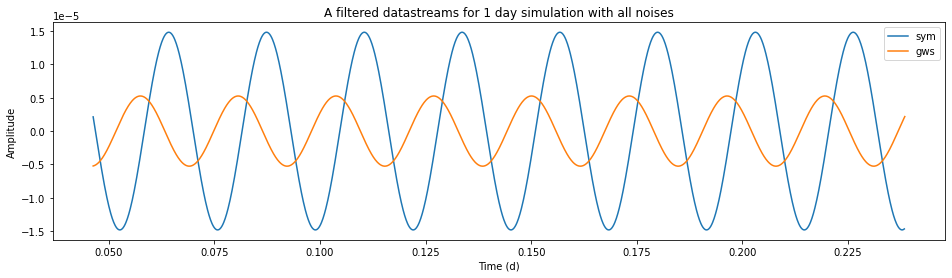

In [13]:
plt.figure(figsize=(16,4))
plt.plot(fsdata[0]/day,fsdata[1],label='sym')
plt.plot((mdata[0]/day)[cutoff-1:-(cutoff+discard)],mdata[1][cutoff-1:-(cutoff+discard)],label='gws')
plt.title('A filtered datastreams for 1 day simulation with all noises')
plt.xlabel('Time (d)')
plt.ylabel('Amplitude')
# plt.xlim(xmin=np.min(fsdata[0]/day),xmax=0.05)
plt.legend()
plt.show()


In [24]:
amp = []
freq_range = np.logspace(-5,-1.5,100) 
for f in freq_range:
    a = 2.8e-4
    p = np.pi*.6 #rad

    GalBin = GalacticBinary(A=a, f=f, phi0=p, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
    GalBin.write('test3.h5')
    rawdata = Data.from_gws('test3.h5',orbit_path)

    # time_elapsed.append(time.time())

    # Afunc = ortho.A2.build(**rawdata.args)
    # time_elapsed.append(time.time())
    A = Afunc(rawdata.measurements)[discard:]
    # time_elapsed.append(time.time())

    # print ("gw = {:.2f}, TDIbuild = {:.2f}, TDIcalc = {:.2f}, Total = {:.2f}".format(time_elapsed[1]-time_elapsed[0],\
    #        time_elapsed[2]-time_elapsed[1], time_elapsed[3]-time_elapsed[2], time_elapsed[3]-time_elapsed[0]))

    t = GalBin.t[discard:]
    # t = model_instru.t[discard:]
    # t = (np.arange(0,len(A)+discard)/4)[discard:]
    mdata = np.array([t,A])
    !rm test3.h5
    amp.append(np.max(A))
amp = np.array(amp)

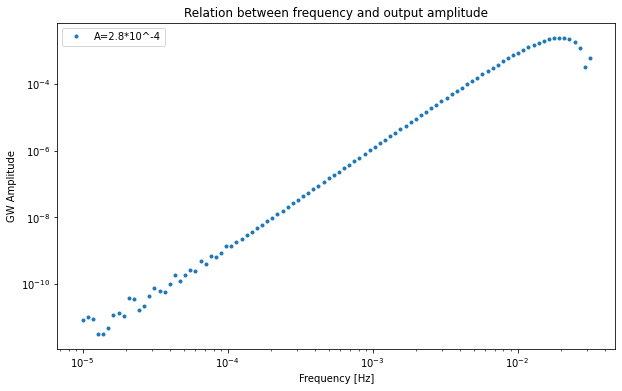

In [66]:
plt.figure(figsize=(10,6))
plt.loglog(freq_range,amp,linestyle='',marker='.',label= "A=2.8*10^-4")
# plt.plot([1e-2]*2,[1e-9,5e-5])
plt.xlabel("Frequency [Hz]")
plt.ylabel("GW Amplitude")
plt.legend()
plt.title("Relation between frequency and output amplitude")
plt.show()
#print (list(np.array(amp,dtype=np.single)))
#print (list(np.array(freq_range,dtype=np.single)))

In [44]:
amp2= np.array([1.9101476e-08, 1.9239652e-08, 1.937812e-08, 1.9516866e-08, 1.9655866e-08, 1.97951e-08, 1.9934548e-08, 2.0074184e-08, 2.0213989e-08, 2.0353937e-08, 2.0494005e-08, 2.0634166e-08, 2.0774396e-08, 2.0914667e-08, 2.1054955e-08, 2.1195227e-08, 2.1335458e-08, 2.1475616e-08, 2.1615673e-08, 2.1755595e-08, 2.1895351e-08, 2.2034909e-08, 2.2174232e-08, 2.2313289e-08, 2.2452042e-08, 2.2590456e-08, 2.2728491e-08, 2.286611e-08, 2.3003274e-08, 2.3139942e-08, 2.327607e-08, 2.341162e-08, 2.3546546e-08, 2.3680803e-08, 2.3814344e-08, 2.3947127e-08, 2.40791e-08, 2.4210214e-08, 2.4340421e-08, 2.4469667e-08, 2.4597902e-08, 2.4725072e-08, 2.4851122e-08, 2.4975993e-08, 2.509963e-08, 2.5221976e-08, 2.5342969e-08, 2.5462548e-08, 2.5580649e-08, 2.569721e-08, 2.5812167e-08, 2.592545e-08, 2.6036993e-08, 2.6146727e-08, 2.625458e-08, 2.6360482e-08, 2.6464358e-08, 2.656613e-08, 2.6665727e-08, 2.6763068e-08, 2.6858073e-08, 2.695066e-08, 2.704075e-08, 2.7128255e-08, 2.7213092e-08, 2.7295172e-08, 2.7374409e-08, 2.7450708e-08, 2.752398e-08, 2.7594131e-08, 2.7661065e-08, 2.7724685e-08, 2.7784893e-08, 2.7841587e-08, 2.7894668e-08, 2.7944031e-08, 2.798957e-08, 2.803118e-08, 2.8068749e-08, 2.810217e-08, 2.813133e-08, 2.8156114e-08, 2.8176409e-08, 2.8192096e-08, 2.8203058e-08, 2.8209172e-08, 2.821032e-08, 2.8206374e-08, 2.819721e-08, 2.8182702e-08, 2.816272e-08, 2.8137135e-08, 2.8105815e-08, 2.8068625e-08, 2.802543e-08, 2.7976098e-08, 2.7920484e-08, 2.7858452e-08, 2.778986e-08, 2.7714563e-08, 2.7632423e-08, 2.7543289e-08, 2.7447017e-08, 2.7343457e-08, 2.7232463e-08, 2.7113881e-08, 2.6987559e-08, 2.6853346e-08, 2.6711088e-08, 2.656063e-08, 2.6401814e-08, 2.6234485e-08, 2.6058483e-08, 2.5873652e-08, 2.5679832e-08, 2.5476862e-08, 2.5264582e-08, 2.5042832e-08, 2.481145e-08, 2.4570275e-08, 2.4319146e-08, 2.4057899e-08, 2.3786372e-08, 2.3504406e-08, 2.3211838e-08, 2.2908507e-08, 2.2594254e-08, 2.2268916e-08, 2.1932335e-08, 2.1584354e-08, 2.1224816e-08, 2.0853562e-08, 2.047044e-08, 2.0075296e-08, 1.9667977e-08, 1.9248338e-08, 1.8816225e-08, 1.8371498e-08, 1.7914012e-08, 1.7443625e-08, 1.6960202e-08, 1.6463607e-08, 1.595371e-08, 1.5430382e-08, 1.48935015e-08, 1.43429455e-08, 1.37786005e-08, 1.3200355e-08, 1.26081e-08, 1.2001738e-08, 1.138117e-08, 1.0746306e-08, 1.0097063e-08, 9.43336e-09, 8.755126e-09, 8.062297e-09, 7.354813e-09, 6.6326256e-09, 5.8956906e-09, 5.1439746e-09, 4.377451e-09, 3.596103e-09, 2.7999232e-09, 1.9889133e-09, 1.1630857e-09, 3.224628e-10, 2.7469113e-10, 7.53915e-10, 1.2412331e-09, 1.7366085e-09, 2.239997e-09, 2.7513478e-09, 3.270602e-09, 3.7976937e-09, 4.332548e-09, 4.875083e-09, 5.4252083e-09, 5.9828236e-09, 6.5478205e-09, 7.1200814e-09, 7.699478e-09, 8.285875e-09, 8.879123e-09, 9.4790655e-09, 1.0085534e-08, 1.069835e-08, 1.131732e-08, 1.1942246e-08, 1.2572911e-08, 1.3209091e-08, 1.3850546e-08, 1.4497026e-08, 1.5148267e-08, 1.5803993e-08, 1.6463911e-08, 1.7127718e-08, 1.7795095e-08, 1.846571e-08, 1.9139216e-08, 1.981525e-08, 2.0493436e-08, 2.117338e-08, 2.1854676e-08, 2.2536899e-08, 2.321961e-08, 2.3902352e-08, 2.4584654e-08, 2.5266027e-08, 2.5945965e-08, 2.662395e-08, 2.7299436e-08, 2.797187e-08, 2.8640681e-08, 2.9305275e-08, 2.9965044e-08, 3.0619365e-08, 3.1267593e-08, 3.1909067e-08, 3.2543113e-08, 3.3169034e-08, 3.378612e-08, 3.4393636e-08, 3.4990844e-08, 3.5576974e-08, 3.6151253e-08, 3.671288e-08, 3.7261046e-08, 3.7794923e-08, 3.8313672e-08, 3.8816427e-08, 3.930233e-08, 3.977048e-08, 4.0219984e-08, 4.0649933e-08, 4.10594e-08, 4.1447453e-08, 4.181314e-08, 4.215551e-08, 4.2473594e-08, 4.2766423e-08, 4.3033012e-08, 4.327238e-08, 4.348353e-08, 4.3665477e-08, 4.3817217e-08, 4.393775e-08, 4.4026084e-08, 4.408122e-08, 4.4102162e-08, 4.408793e-08, 4.4037538e-08, 4.3950013e-08, 4.3824397e-08, 4.3659735e-08, 4.3455096e-08, 4.3209557e-08, 4.2922217e-08, 4.2592198e-08, 4.2218645e-08, 4.180072e-08, 4.133763e-08, 4.0828592e-08, 4.0272873e-08, 3.9669768e-08, 3.9018612e-08, 3.8318788e-08, 3.7569713e-08, 3.677086e-08, 3.592175e-08, 3.502196e-08, 3.4071117e-08, 3.3068922e-08, 3.2015127e-08, 3.0909558e-08, 2.9752115e-08, 2.8542765e-08, 2.7281555e-08, 2.5968617e-08, 2.4604166e-08, 2.3188504e-08, 2.1722025e-08, 2.0205222e-08, 1.8638687e-08, 1.702311e-08, 1.5359293e-08, 1.3648143e-08, 1.1890685e-08, 1.00880575e-08, 8.2415195e-09, 6.352452e-09, 4.422364e-09, 2.4528908e-09, 4.4580162e-10, 2.9978617e-09, 6.7531096e-09, 1.0564734e-08, 1.4428518e-08, 1.8339989e-08, 2.2294413e-08, 2.6286795e-08, 3.0311877e-08, 3.4364135e-08, 3.8437783e-08, 4.252676e-08, 4.6624756e-08, 5.0725184e-08, 5.4821214e-08, 5.890574e-08, 6.297142e-08, 6.701065e-08, 7.1015606e-08, 7.49782e-08, 7.889015e-08, 8.274293e-08, 8.652782e-08, 9.02359e-08, 9.385808e-08, 9.738507e-08, 1.0080746e-07, 1.0411569e-07, 1.0730007e-07, 1.1035082e-07, 1.13258075e-07, 1.1601192e-07, 1.18602394e-07, 1.2101953e-07, 1.2325337e-07, 1.2529404e-07, 1.2713166e-07, 1.2875651e-07, 1.3015902e-07, 1.3132974e-07, 1.3225946e-07, 1.3293918e-07, 1.333602e-07, 1.3351413e-07, 1.3339293e-07, 1.3298899e-07, 1.3229507e-07, 1.3130447e-07, 1.3001102e-07, 1.2840906e-07, 1.2649362e-07, 1.2426035e-07, 1.217056e-07, 1.1882651e-07, 1.15621e-07, 1.12087825e-07, 1.0822666e-07, 1.0403809e-07, 9.95237e-08, 9.468611e-08, 8.9528974e-08, 8.4057085e-08, 7.8276365e-08, 7.2193934e-08, 6.5818114e-08, 5.9158484e-08, 5.22259e-08, 4.5032515e-08, 3.7591807e-08, 2.9918592e-08, 2.2029043e-08, 1.3940688e-08, 5.6724154e-09, 1.396124e-09, 6.1633667e-09, 1.0996366e-08, 1.5881687e-08, 2.0805173e-08, 2.5751964e-08, 3.0706524e-08, 3.5652658e-08, 4.0573557e-08, 4.545183e-08, 5.0269552e-08, 5.5008293e-08, 5.9649196e-08, 6.4173e-08, 6.856016e-08, 7.279085e-08, 7.684506e-08, 8.070272e-08, 8.43437e-08, 8.774796e-08, 9.0895625e-08, 9.37671e-08, 9.6343136e-08, 9.8604986e-08, 1.00534464e-07, 1.0211412e-07, 1.033273e-07, 1.0415831e-07, 1.0459254e-07, 1.0461654e-07, 1.0421822e-07, 1.0338693e-07, 1.021136e-07, 1.0039088e-07, 9.8213214e-08, 9.557705e-08, 9.248088e-08, 8.89254e-08, 8.491358e-08, 8.045081e-08, 7.554496e-08, 7.0206475e-08, 6.4448464e-08, 5.828673e-08, 5.173985e-08, 4.482919e-08, 3.757894e-08, 3.0016114e-08, 2.2170534e-08, 1.4074795e-08, 5.7642167e-09, 5.3317666e-09, 2.0685647e-08, 3.6195864e-08, 5.178153e-08, 6.7358066e-08, 8.283753e-08, 9.812905e-08, 1.13139215e-07, 1.2777258e-07, 1.4193222e-07, 1.5552023e-07, 1.6843843e-07, 1.8058894e-07, 1.9187492e-07, 2.0220126e-07, 2.1147538e-07, 2.1960797e-07, 2.2651383e-07, 2.321127e-07, 2.3633007e-07, 2.3909803e-07, 2.403562e-07, 2.400524e-07, 2.3814367e-07, 2.345969e-07, 2.2938971e-07, 2.2251113e-07, 2.1396228e-07, 2.0375697e-07, 1.9192227e-07, 1.7849895e-07, 1.6354187e-07, 1.4712022e-07, 1.293177e-07, 1.1023251e-07, 8.9977355e-08, 6.867909e-08, 4.647842e-08, 2.3529328e-08, 3.0746778e-09, 1.3109044e-08, 2.6843416e-08, 4.0601474e-08, 5.4265975e-08, 6.7715696e-08, 8.082637e-08, 9.347173e-08, 1.05524656e-07, 1.1685832e-07, 1.273475e-07, 1.3686997e-07, 1.4530777e-07, 1.5254875e-07, 1.58488e-07, 1.6302934e-07, 1.6608675e-07, 1.6758587e-07, 1.674654e-07, 1.6567847e-07, 1.6219393e-07, 1.5699743e-07, 1.5009262e-07, 1.4150191e-07, 1.3126733e-07, 1.1945096e-07, 1.0613535e-07, 9.142358e-08, 7.5439104e-08, 5.8325355e-08, 4.024503e-08, 2.1379094e-08, 5.344892e-09, 3.2516255e-08, 6.71254e-08, 1.01522005e-07, 1.3527777e-07, 1.6795526e-07, 1.9911326e-07, 2.2831254e-07, 2.5512196e-07, 2.7912478e-07, 2.9992518e-07, 3.1715507e-07, 3.3048053e-07, 3.3960856e-07, 3.4429343e-07, 3.443426e-07, 3.3962252e-07, 3.3006359e-07, 3.156646e-07, 2.964962e-07, 2.7270366e-07, 2.4450833e-07, 2.122082e-07, 1.7617711e-07, 1.3686254e-07, 9.478224e-08, 5.0519233e-08, 8.5220835e-09, 2.3217895e-08, 5.0682356e-08, 7.782638e-08, 1.0418841e-07, 1.2930106e-07, 1.5269903e-07, 1.7392773e-07, 1.9255201e-07, 2.0816529e-07, 2.2039858e-07, 2.2892951e-07, 2.3349091e-07, 2.3387892e-07, 2.2996035e-07, 2.2167904e-07, 2.0906117e-07, 1.922191e-07, 1.7135376e-07, 1.4675521e-07, 1.18801495e-07, 8.795536e-08, 5.4759024e-08, 1.9826825e-08, 3.0611954e-08, 9.1296535e-08, 1.5106004e-07, 2.0858441e-07, 2.6254838e-07, 3.1165757e-07, 3.5467582e-07, 3.904572e-07, 4.179778e-07, 4.3636658e-07, 4.4493433e-07, 4.4320004e-07, 4.3091353e-07, 4.0807367e-07, 3.7494135e-07, 3.320464e-07, 2.8018772e-07, 2.2042646e-07, 1.5407146e-07, 8.265716e-08, 1.8226528e-08, 3.8514308e-08, 8.488129e-08, 1.2983868e-07, 1.7210964e-07, 2.1043864e-07, 2.4362882e-07, 2.705801e-07, 2.9032688e-07, 3.0207426e-07, 3.0523114e-07, 2.9943956e-07, 2.8459814e-07, 2.608795e-07, 2.2873938e-07, 1.8891785e-07, 1.4243066e-07, 9.055127e-08, 3.4782797e-08, 4.449074e-08, 1.3741531e-07, 2.2729698e-07, 3.1102164e-07, 3.8556337e-07, 4.4809573e-07, 4.961029e-07, 5.2748646e-07, 5.4066317e-07, 5.346504e-07, 5.091332e-07, 4.6451098e-07, 4.0191875e-07, 3.2322131e-07, 2.3097793e-07, 1.2837725e-07, 3.3365602e-08, 5.2932304e-08, 1.239752e-07, 1.9141983e-07, 2.523958e-07, 3.0417863e-07, 3.4431392e-07, 3.7073815e-07, 3.8189003e-07, 3.7680718e-07, 3.5520185e-07, 3.1751125e-07, 2.6491745e-07, 1.9933411e-07, 1.2335752e-07, 4.323546e-08, 8.4135245e-08, 2.1362126e-07, 3.3492339e-07, 4.4192765e-07, 5.2898775e-07, 5.912337e-07, 6.2486026e-07, 6.273776e-07, 5.978082e-07, 5.3681595e-07, 4.4675372e-07, 3.3162254e-07, 1.96937e-07, 5.5063648e-08, 5.78646e-08, 1.6051293e-07, 2.562401e-07, 3.3937496e-07, 4.047269e-07, 4.4791938e-07, 4.656965e-07, 4.5618242e-07, 4.1907296e-07, 3.557422e-07, 2.6925053e-07, 1.6424568e-07, 6.89263e-08, 1.311803e-07, 2.9980785e-07, 4.5142892e-07, 5.755689e-07, 6.631967e-07, 7.0741595e-07, 7.0404894e-07, 6.520662e-07, 5.538174e-07, 4.150325e-07, 2.4457663e-07, 8.480021e-08, 8.627139e-08, 2.2413109e-07, 3.512028e-07, 4.544315e-07, 5.251282e-07, 5.567471e-07, 5.4552544e-07, 4.9094194e-07, 3.959433e-07, 2.6689912e-07, 1.13268754e-07, 1.0680105e-07, 3.2165335e-07, 5.1227755e-07, 6.616643e-07, 7.5576384e-07, 7.848795e-07, 7.4475264e-07, 6.372182e-07, 4.7033657e-07, 2.5795202e-07, 1.239908e-07, 1.4322418e-07, 3.2735153e-07, 4.8407696e-07, 5.9722817e-07, 6.54202e-07, 6.474346e-07, 5.7545856e-07, 4.4340385e-07, 2.6284462e-07, 1.4736041e-07, 2.6091038e-07, 5.0475836e-07, 6.9740213e-07, 8.1653127e-07, 8.4716754e-07, 7.8370596e-07, 6.310056e-07, 4.0433525e-07, 1.7213536e-07, 1.7513393e-07, 3.3378421e-07, 5.4651025e-07, 6.9815013e-07, 7.6806845e-07, 7.4480516e-07, 6.28052e-07, 4.293416e-07, 2.0107223e-07, 2.0499935e-07, 5.016325e-07, 7.354059e-07, 8.7348343e-07, 8.948841e-07, 7.9393703e-07, 5.817942e-07, 2.8564656e-07, 2.3486955e-07, 2.884349e-07, 5.7808825e-07, 7.899297e-07, 8.898079e-07, 8.587957e-07, 6.969747e-07, 4.245449e-07, 2.6964528e-07, 3.8768798e-07, 6.9144795e-07, 8.872789e-07, 9.409122e-07, 8.4038226e-07, 5.9904767e-07, 3.042654e-07, 3.0956764e-07, 4.1880094e-07, 7.607873e-07, 9.775173e-07, 1.0259449e-06, 8.9129156e-07, 5.9143565e-07, 3.4931986e-07, 3.9048845e-07, 7.3016037e-07, 9.336293e-07, 9.58809e-07, 7.9714596e-07, 4.7679146e-07, 3.9416744e-07, 4.0103336e-07, 7.2847223e-07, 1.0611004e-06, 1.1812494e-06, 1.0557823e-06, 7.023865e-07, 4.447726e-07, 4.7381693e-07, 8.1750414e-07, 9.807491e-07, 9.2322136e-07, 6.5402594e-07, 4.932781e-07, 5.018696e-07, 6.695415e-07, 1.137333e-06, 1.3430323e-06, 1.226609e-06, 8.0470124e-07, 5.565944e-07, 5.7387325e-07, 8.961243e-07, 9.874501e-07, 8.200714e-07, 6.0671744e-07, 6.172673e-07, 6.2801035e-07, 1.1440122e-06, 1.4981623e-06, 1.4435415e-06, 9.799613e-07, 6.8456876e-07, 6.9637304e-07, 9.2850985e-07, 9.54406e-07, 7.334649e-07, 7.4621e-07, 7.591954e-07, 9.195933e-07, 1.5545446e-06, 1.7157496e-06, 1.3332842e-06, 8.2754684e-07, 8.419337e-07, 9.0551555e-07, 9.2442434e-07, 8.866326e-07, 9.0205975e-07, 9.177003e-07, 1.1977413e-06, 1.8513381e-06, 1.8616735e-06, 1.199658e-06, 1.0003391e-06, 1.0177461e-06, 1.035436e-06, 1.053415e-06, 1.0716277e-06, 1.0903759e-06, 1.1391032e-06, 2.0173295e-06, 2.1146323e-06, 1.3604897e-06, 1.1884827e-06, 1.209139e-06, 1.230159e-06, 1.2515554e-06, 1.2732863e-06, 1.2954135e-06, 1.7431175e-06, 2.4265223e-06, 2.0463995e-06, 1.3877947e-06, 1.4118881e-06, 1.4364962e-06, 1.4614332e-06, 1.486848e-06, 1.512655e-06, 1.7995712e-06, 2.6923146e-06, 2.283446e-06, 1.6205368e-06, 1.6486911e-06, 1.6773198e-06, 1.706456e-06, 1.736126e-06, 1.7662641e-06, 2.5060176e-06, 2.98728e-06, 1.8598862e-06, 1.8921911e-06, 1.9250485e-06, 1.958468e-06, 1.9924755e-06, 2.0270713e-06, 2.4035817e-06, 3.3493382e-06, 2.3323153e-06, 2.1715282e-06, 2.209239e-06, 2.2476095e-06, 2.286542e-06, 2.3262357e-06, 2.919398e-06, 3.6570439e-06, 2.4495587e-06, 2.49204e-06, 2.535318e-06, 2.5792792e-06, 2.6240484e-06, 2.6695586e-06, 3.9498896e-06, 3.352317e-06, 2.8109664e-06, 2.8596407e-06, 2.909267e-06, 2.9597968e-06, 3.0111148e-06, 4.0951236e-06, 3.993117e-06, 3.170374e-06, 3.2255114e-06, 3.2814244e-06, 3.3383367e-06, 3.3961883e-06, 4.643965e-06, 4.076519e-06, 3.5758715e-06, 3.6379183e-06, 3.7008951e-06, 3.7649797e-06, 3.8303824e-06, 5.38556e-06, 3.9642687e-06, 4.0329282e-06, 4.102813e-06, 4.1739627e-06, 4.2460806e-06, 5.470258e-06, 4.757401e-06, 4.4707926e-06, 4.5481597e-06, 4.6269734e-06, 4.707123e-06, 5.455456e-06, 5.6664644e-06, 4.9558957e-06, 5.04155e-06, 5.128978e-06, 5.2178307e-06, 6.0651287e-06, 5.90216e-06, 5.4934026e-06, 5.5885243e-06, 5.6852805e-06, 5.783603e-06, 7.3164956e-06, 5.9855024e-06, 6.0890256e-06, 6.194174e-06, 6.3014186e-06, 6.410434e-06, 7.966912e-06, 6.634168e-06, 6.7489373e-06, 6.865455e-06, 6.9806856e-06, 8.6384525e-06, 7.2277317e-06, 7.352596e-06, 7.4798145e-06, 7.6089896e-06, 8.350678e-06, 7.8742605e-06, 8.010032e-06, 8.148611e-06, 8.289448e-06, 8.432344e-06, 8.609729e-06, 8.726025e-06, 8.877096e-06, 9.030401e-06, 9.443014e-06, 9.344781e-06, 9.506035e-06, 9.670196e-06, 9.818608e-06, 1.138092e-05, 1.0179276e-05, 1.0354959e-05, 1.05334075e-05, 1.0715311e-05, 1.2621305e-05, 1.108795e-05, 1.127905e-05, 1.1473595e-05, 1.1670881e-05, 1.187207e-05, 1.2077173e-05, 1.2285181e-05, 1.2496812e-05, 1.433889e-05, 1.2931056e-05, 1.3153475e-05, 1.338017e-05, 1.5042494e-05, 1.3844912e-05, 1.40831635e-05, 1.4325742e-05, 1.4572163e-05, 1.4822849e-05, 1.5077614e-05, 1.5337304e-05, 1.5601188e-05, 1.5869371e-05, 1.6142185e-05, 1.6419408e-05, 1.6699838e-05, 1.6994281e-05, 1.7280288e-05, 1.7577424e-05, 1.7879687e-05, 1.8186855e-05, 1.8499077e-05, 1.881694e-05, 1.9139918e-05, 1.9468449e-05, 1.9802368e-05, 2.0142325e-05, 2.2449824e-05, 2.083944e-05, 2.1196829e-05, 2.1560074e-05, 2.2161652e-05, 2.2305536e-05, 2.26879e-05, 2.3076827e-05, 2.347217e-05, 2.3874109e-05, 2.4282837e-05, 2.5884292e-05, 2.5121632e-05, 2.5551486e-05, 2.5988536e-05, 2.643339e-05, 2.6885113e-05, 2.7344948e-05, 2.7833732e-05, 2.828846e-05, 2.877225e-05, 3.125713e-05, 2.9763447e-05, 3.026853e-05, 3.0788706e-05, 3.1314747e-05, 3.184865e-05, 3.23926e-05, 3.2944576e-05, 3.3507346e-05, 3.4078523e-05, 3.465932e-05, 3.5249996e-05, 3.5850753e-05])
freq_range2 = np.array([1e-05, 1.0057788e-05, 1.0115911e-05, 1.017437e-05, 1.0233166e-05, 1.0292302e-05, 1.035178e-05, 1.0411601e-05, 1.0471768e-05, 1.0532283e-05, 1.0593148e-05, 1.0654364e-05, 1.0715934e-05, 1.077786e-05, 1.0840144e-05, 1.0902787e-05, 1.0965793e-05, 1.1029163e-05, 1.1092899e-05, 1.11570025e-05, 1.12214775e-05, 1.1286325e-05, 1.1351547e-05, 1.1417146e-05, 1.1483125e-05, 1.1549483e-05, 1.1616226e-05, 1.1683355e-05, 1.1750872e-05, 1.1818778e-05, 1.1887077e-05, 1.1955771e-05, 1.20248615e-05, 1.2094351e-05, 1.2164243e-05, 1.2234538e-05, 1.23052405e-05, 1.237635e-05, 1.2447871e-05, 1.2519806e-05, 1.2592156e-05, 1.2664925e-05, 1.2738114e-05, 1.2811725e-05, 1.2885762e-05, 1.2960227e-05, 1.3035123e-05, 1.3110451e-05, 1.3186214e-05, 1.3262415e-05, 1.3339057e-05, 1.3416141e-05, 1.3493672e-05, 1.3571649e-05, 1.36500785e-05, 1.372896e-05, 1.3808298e-05, 1.3888094e-05, 1.3968352e-05, 1.4049072e-05, 1.413026e-05, 1.4211917e-05, 1.4294045e-05, 1.4376648e-05, 1.4459729e-05, 1.454329e-05, 1.4627333e-05, 1.4711863e-05, 1.479688e-05, 1.488239e-05, 1.4968393e-05, 1.5054893e-05, 1.51418935e-05, 1.5229396e-05, 1.5317404e-05, 1.5405922e-05, 1.549495e-05, 1.5584494e-05, 1.5674554e-05, 1.5765136e-05, 1.585624e-05, 1.5947871e-05, 1.604003e-05, 1.6132724e-05, 1.6225953e-05, 1.631972e-05, 1.641403e-05, 1.6508884e-05, 1.6604286e-05, 1.670024e-05, 1.6796748e-05, 1.6893815e-05, 1.6991442e-05, 1.7089633e-05, 1.7188391e-05, 1.728772e-05, 1.7387623e-05, 1.7488104e-05, 1.7589166e-05, 1.769081e-05, 1.7793043e-05, 1.7895867e-05, 1.7999286e-05, 1.8103301e-05, 1.8207917e-05, 1.8313138e-05, 1.8418967e-05, 1.8525407e-05, 1.8632463e-05, 1.8740138e-05, 1.8848434e-05, 1.8957357e-05, 1.9066909e-05, 1.9177094e-05, 1.9287914e-05, 1.9399376e-05, 1.9511483e-05, 1.9624238e-05, 1.9737643e-05, 1.9851705e-05, 1.9966425e-05, 2.0081809e-05, 2.0197858e-05, 2.0314577e-05, 2.0431973e-05, 2.0550047e-05, 2.0668802e-05, 2.0788244e-05, 2.0908377e-05, 2.1029204e-05, 2.1150729e-05, 2.1272956e-05, 2.1395888e-05, 2.1519532e-05, 2.1643891e-05, 2.1768969e-05, 2.1894768e-05, 2.2021295e-05, 2.2148552e-05, 2.2276547e-05, 2.2405278e-05, 2.2534756e-05, 2.266498e-05, 2.2795959e-05, 2.2927694e-05, 2.3060189e-05, 2.319345e-05, 2.3327482e-05, 2.3462288e-05, 2.3597873e-05, 2.3734243e-05, 2.38714e-05, 2.4009349e-05, 2.4148096e-05, 2.4287643e-05, 2.4427998e-05, 2.4569164e-05, 2.4711146e-05, 2.4853949e-05, 2.4997576e-05, 2.5142033e-05, 2.5287325e-05, 2.5433457e-05, 2.5580433e-05, 2.5728259e-05, 2.587694e-05, 2.6026479e-05, 2.6176882e-05, 2.6328154e-05, 2.6480302e-05, 2.6633326e-05, 2.6787238e-05, 2.6942038e-05, 2.709773e-05, 2.7254326e-05, 2.7411825e-05, 2.7570233e-05, 2.7729558e-05, 2.7889802e-05, 2.8050974e-05, 2.8213077e-05, 2.8376116e-05, 2.8540098e-05, 2.8705026e-05, 2.8870909e-05, 2.903775e-05, 2.9205556e-05, 2.937433e-05, 2.954408e-05, 2.971481e-05, 2.9886529e-05, 3.0059238e-05, 3.0232946e-05, 3.0407658e-05, 3.0583382e-05, 3.076012e-05, 3.0937877e-05, 3.1116662e-05, 3.129648e-05, 3.147734e-05, 3.165924e-05, 3.1842195e-05, 3.2026208e-05, 3.2211283e-05, 3.2397427e-05, 3.2584645e-05, 3.2772947e-05, 3.296234e-05, 3.3152824e-05, 3.3344408e-05, 3.35371e-05, 3.3730907e-05, 3.3925833e-05, 3.4121887e-05, 3.4319073e-05, 3.4517398e-05, 3.4716868e-05, 3.491749e-05, 3.5119276e-05, 3.5322224e-05, 3.5526347e-05, 3.573165e-05, 3.5938137e-05, 3.614582e-05, 3.63547e-05, 3.6564787e-05, 3.677609e-05, 3.6988615e-05, 3.7202368e-05, 3.7417354e-05, 3.7633585e-05, 3.7851063e-05, 3.80698e-05, 3.82898e-05, 3.851107e-05, 3.873362e-05, 3.8957456e-05, 3.9182585e-05, 3.9409017e-05, 3.9636754e-05, 3.9865812e-05, 4.009619e-05, 4.03279e-05, 4.056095e-05, 4.0795345e-05, 4.1031097e-05, 4.126821e-05, 4.1506693e-05, 4.1746553e-05, 4.19878e-05, 4.223044e-05, 4.2474487e-05, 4.271994e-05, 4.296681e-05, 4.321511e-05, 4.3464846e-05, 4.3716023e-05, 4.3968652e-05, 4.422274e-05, 4.4478296e-05, 4.473533e-05, 4.499385e-05, 4.5253862e-05, 4.551538e-05, 4.5778404e-05, 4.604295e-05, 4.630903e-05, 4.6576642e-05, 4.6845802e-05, 4.7116515e-05, 4.7388796e-05, 4.766265e-05, 4.7938083e-05, 4.821511e-05, 4.849374e-05, 4.8773978e-05, 4.9055838e-05, 4.9339324e-05, 4.962445e-05, 4.991122e-05, 5.019965e-05, 5.0489747e-05, 5.078152e-05, 5.107498e-05, 5.1370134e-05, 5.1666997e-05, 5.1965573e-05, 5.2265874e-05, 5.256791e-05, 5.2871696e-05, 5.317723e-05, 5.3484535e-05, 5.3793614e-05, 5.410448e-05, 5.441714e-05, 5.4731612e-05, 5.5047898e-05, 5.5366014e-05, 5.5685963e-05, 5.6007764e-05, 5.6331428e-05, 5.6656958e-05, 5.6984372e-05, 5.7313675e-05, 5.7644884e-05, 5.7978006e-05, 5.831305e-05, 5.8650035e-05, 5.8988964e-05, 5.9329854e-05, 5.967271e-05, 6.001755e-05, 6.0364386e-05, 6.071322e-05, 6.106408e-05, 6.1416955e-05, 6.1771876e-05, 6.212885e-05, 6.248788e-05, 6.284899e-05, 6.321219e-05, 6.357748e-05, 6.3944884e-05, 6.4314416e-05, 6.468608e-05, 6.505989e-05, 6.543586e-05, 6.5814005e-05, 6.6194334e-05, 6.657686e-05, 6.69616e-05, 6.734856e-05, 6.773776e-05, 6.812921e-05, 6.852292e-05, 6.8918904e-05, 6.9317175e-05, 6.9717746e-05, 7.012064e-05, 7.052585e-05, 7.093341e-05, 7.1343326e-05, 7.175561e-05, 7.2170275e-05, 7.258734e-05, 7.3006806e-05, 7.34287e-05, 7.3853036e-05, 7.427982e-05, 7.4709074e-05, 7.514081e-05, 7.557504e-05, 7.601178e-05, 7.645104e-05, 7.689284e-05, 7.733719e-05, 7.778411e-05, 7.8233614e-05, 7.868571e-05, 7.914043e-05, 7.959777e-05, 8.0057755e-05, 8.0520396e-05, 8.0985716e-05, 8.145372e-05, 8.192443e-05, 8.2397855e-05, 8.287402e-05, 8.335294e-05, 8.3834624e-05, 8.4319094e-05, 8.4806365e-05, 8.5296444e-05, 8.578936e-05, 8.628512e-05, 8.678375e-05, 8.728527e-05, 8.7789675e-05, 8.8297e-05, 8.880725e-05, 8.932046e-05, 8.983663e-05, 9.035578e-05, 9.087794e-05, 9.1403104e-05, 9.193131e-05, 9.246257e-05, 9.29969e-05, 9.353431e-05, 9.4074836e-05, 9.461848e-05, 9.516527e-05, 9.5715215e-05, 9.626834e-05, 9.682466e-05, 9.7384196e-05, 9.794697e-05, 9.851299e-05, 9.908228e-05, 9.965486e-05, 0.000100230754, 0.00010080997, 0.00010139254, 0.000101978476, 0.00010256779, 0.00010316052, 0.00010375667, 0.000104356266, 0.00010495933, 0.000105565865, 0.00010617592, 0.00010678949, 0.00010740662, 0.0001080273, 0.00010865158, 0.00010927946, 0.00010991097, 0.00011054613, 0.00011118496, 0.00011182748, 0.00011247372, 0.000113123686, 0.000113777416, 0.000114434915, 0.00011509622, 0.000115761344, 0.00011643031, 0.00011710315, 0.00011777987, 0.000118460506, 0.00011914507, 0.000119833596, 0.00012052609, 0.0001212226, 0.00012192313, 0.0001226277, 0.00012333634, 0.0001240491, 0.00012476595, 0.00012548696, 0.00012621214, 0.0001269415, 0.00012767507, 0.00012841288, 0.00012915497, 0.00012990134, 0.00013065201, 0.00013140704, 0.00013216642, 0.00013293019, 0.00013369837, 0.000134471, 0.00013524809, 0.00013602967, 0.00013681577, 0.0001376064, 0.0001384016, 0.00013920141, 0.00014000584, 0.00014081491, 0.00014162867, 0.00014244711, 0.0001432703, 0.00014409823, 0.00014493096, 0.0001457685, 0.00014661087, 0.00014745811, 0.00014831025, 0.00014916732, 0.00015002933, 0.00015089633, 0.00015176834, 0.00015264539, 0.00015352751, 0.00015441472, 0.00015530706, 0.00015620455, 0.00015710724, 0.00015801514, 0.00015892829, 0.0001598467, 0.00016077045, 0.00016169951, 0.00016263395, 0.00016357379, 0.00016451906, 0.00016546978, 0.00016642602, 0.00016738777, 0.00016835508, 0.00016932798, 0.0001703065, 0.00017129068, 0.00017228055, 0.00017327613, 0.00017427746, 0.00017528459, 0.00017629754, 0.00017731634, 0.00017834103, 0.00017937164, 0.0001804082, 0.00018145074, 0.00018249932, 0.00018355396, 0.00018461469, 0.00018568155, 0.00018675458, 0.00018783381, 0.00018891928, 0.00019001102, 0.00019110907, 0.00019221345, 0.00019332423, 0.00019444143, 0.00019556507, 0.00019669521, 0.00019783189, 0.00019897513, 0.00020012498, 0.00020128148, 0.00020244464, 0.00020361455, 0.00020479121, 0.00020597466, 0.00020716497, 0.00020836215, 0.00020956623, 0.00021077729, 0.00021199534, 0.00021322044, 0.00021445261, 0.00021569189, 0.00021693835, 0.00021819201, 0.00021945291, 0.0002207211, 0.00022199661, 0.0002232795, 0.0002245698, 0.00022586755, 0.00022717282, 0.00022848562, 0.000229806, 0.00023113402, 0.00023246971, 0.00023381312, 0.00023516429, 0.00023652326, 0.0002378901, 0.00023926483, 0.00024064751, 0.00024203818, 0.0002434369, 0.0002448437, 0.0002462586, 0.0002476817, 0.000249113, 0.00025055258, 0.0002520005, 0.00025345676, 0.00025492147, 0.00025639462, 0.0002578763, 0.00025936653, 0.00026086537, 0.00026237287, 0.0002638891, 0.00026541407, 0.00026694784, 0.0002684905, 0.00027004207, 0.00027160262, 0.00027317216, 0.00027475078, 0.00027633854, 0.00027793544, 0.0002795416, 0.00028115703, 0.0002827818, 0.00028441596, 0.00028605954, 0.00028771264, 0.0002893753, 0.00029104756, 0.00029272947, 0.00029442113, 0.00029612254, 0.0002978338, 0.00029955493, 0.00030128603, 0.0003030271, 0.00030477825, 0.00030653953, 0.000308311, 0.00031009267, 0.00031188465, 0.000313687, 0.00031549972, 0.00031732296, 0.00031915674, 0.00032100108, 0.0003228561, 0.00032472186, 0.00032659838, 0.00032848574, 0.000330384, 0.00033229325, 0.00033421352, 0.0003361449, 0.00033808744, 0.00034004118, 0.00034200624, 0.00034398265, 0.00034597047, 0.0003479698, 0.00034998066, 0.00035200315, 0.00035403733, 0.00035608324, 0.000358141, 0.00036021066, 0.00036229225, 0.0003643859, 0.00036649164, 0.00036860953, 0.00037073967, 0.00037288212, 0.00037503697, 0.00037720424, 0.00037938406, 0.00038157648, 0.00038378153, 0.00038599936, 0.00038823, 0.00039047352, 0.00039273003, 0.00039499954, 0.0003972822, 0.00039957804, 0.00040188714, 0.0004042096, 0.00040654544, 0.00040889482, 0.00041125776, 0.00041363438, 0.0004160247, 0.00041842886, 0.0004208469, 0.0004232789, 0.00042572498, 0.0004281852, 0.0004306596, 0.00043314832, 0.00043565143, 0.000438169, 0.00044070111, 0.00044324785, 0.00044580933, 0.0004483856, 0.00045097675, 0.00045358288, 0.00045620408, 0.00045884043, 0.000461492, 0.0004641589, 0.0004668412, 0.000469539, 0.0004722524, 0.00047498147, 0.00047772634, 0.00048048704, 0.00048326372, 0.00048605644, 0.00048886525, 0.00049169036, 0.00049453176, 0.0004973896, 0.00050026394, 0.0005031549, 0.0005060626, 0.000508987, 0.0005119284, 0.00051488675, 0.0005178622, 0.00052085484, 0.0005238648, 0.00052689214, 0.000529937, 0.0005329994, 0.0005360795, 0.00053917745, 0.0005422933, 0.00054542714, 0.0005485791, 0.00055174925, 0.0005549377, 0.00055814465, 0.00056137005, 0.00056461414, 0.00056787697, 0.00057115866, 0.0005744593, 0.000577779, 0.0005811179, 0.0005844761, 0.0005878537, 0.00059125083, 0.0005946676, 0.0005981041, 0.00060156046, 0.0006050368, 0.0006085332, 0.00061204983, 0.00061558676, 0.0006191442, 0.00062272215, 0.0006263207, 0.0006299402, 0.0006335805, 0.0006372419, 0.0006409244, 0.0006446282, 0.0006483534, 0.0006521002, 0.00065586856, 0.00065965875, 0.0006634708, 0.0006673049, 0.00067116116, 0.0006750397, 0.0006789407, 0.00068286416, 0.00068681035, 0.00069077936, 0.00069477124, 0.0006987862, 0.00070282444, 0.00070688594, 0.00071097095, 0.00071507954, 0.0007192119, 0.00072336814, 0.0007275484, 0.0007317528, 0.00073598145, 0.00074023457, 0.0007445123, 0.0007488147, 0.000753142, 0.0007574943, 0.00076187175, 0.0007662745, 0.0007707027, 0.0007751565, 0.00077963603, 0.0007841414, 0.0007886729, 0.0007932305, 0.00079781446, 0.0008024249, 0.000807062, 0.0008117259, 0.00081641675, 0.0008211347, 0.0008258799, 0.0008306526, 0.0008354528, 0.0008402808, 0.00084513664, 0.00085002056, 0.0008549327, 0.00085987325, 0.0008648423, 0.00086984015, 0.0008748668, 0.00087992253, 0.0008850075, 0.00089012185, 0.0008952657, 0.00090043934, 0.0009056428, 0.00091087644, 0.00091614027, 0.0009214345, 0.0009267593, 0.00093211496, 0.0009375015, 0.00094291917, 0.00094836816, 0.00095384865, 0.00095936086, 0.00096490484, 0.0009704809, 0.00097608916, 0.0009817298, 0.0009874031, 0.0009931092, 0.0009988482, 0.0010046205, 0.001010426, 0.0010162651, 0.0010221379, 0.0010280447, 0.0010339856, 0.0010399609, 0.0010459707, 0.0010520152, 0.0010580947, 0.0010642093, 0.0010703591, 0.0010765446, 0.0010827659, 0.001089023, 0.0010953163, 0.001101646, 0.0011080122, 0.0011144152, 0.0011208553, 0.0011273326, 0.0011338473, 0.0011403996, 0.0011469898, 0.0011536181, 0.0011602847, 0.0011669898, 0.0011737337, 0.0011805166, 0.0011873386, 0.0011942, 0.0012011011, 0.0012080421, 0.0012150232, 0.0012220447, 0.0012291067, 0.0012362095, 0.0012433535, 0.0012505386, 0.0012577652, 0.0012650337, 0.0012723441, 0.0012796968, 0.0012870921, 0.00129453, 0.0013020108, 0.001309535, 0.0013171027, 0.001324714, 0.0013323693, 0.0013400689, 0.0013478129, 0.0013556018, 0.0013634356, 0.0013713147, 0.0013792394, 0.0013872097, 0.0013952262, 0.001403289, 0.0014113985, 0.0014195548, 0.0014277581, 0.001436009, 0.0014443075, 0.0014526539, 0.0014610486, 0.0014694917, 0.0014779838, 0.0014865248, 0.0014951152, 0.0015037553, 0.0015124453, 0.0015211855, 0.0015299763, 0.0015388178, 0.0015477104, 0.0015566543, 0.00156565, 0.0015746977, 0.0015837976, 0.0015929502, 0.0016021556, 0.0016114142, 0.0016207264, 0.0016300924, 0.0016395125, 0.001648987, 0.0016585162, 0.0016681006, 0.0016777402, 0.0016874357, 0.0016971871, 0.001706995, 0.0017168594, 0.0017267809, 0.0017367597, 0.0017467962, 0.0017568907, 0.0017670435, 0.001777255, 0.0017875255, 0.0017978554, 0.001808245, 0.0018186945, 0.0018292045, 0.0018397752, 0.001850407, 0.0018611003, 0.0018718553, 0.0018826724, 0.0018935521, 0.0019044947, 0.0019155005, 0.00192657, 0.0019377033, 0.0019489011, 0.0019601635, 0.001971491, 0.001982884, 0.0019943428, 0.002005868, 0.0020174594, 0.0020291181, 0.002040844, 0.0020526377, 0.0020644998, 0.00207643, 0.0020884294, 0.0021004982, 0.0021126368, 0.0021248453, 0.0021371245, 0.0021494746, 0.002161896, 0.0021743895, 0.002186955, 0.002199593, 0.0022123042, 0.002225089, 0.0022379472, 0.00225088, 0.0022638876, 0.0022769703, 0.0022901285, 0.0023033628, 0.0023166738, 0.0023300615, 0.0023435266, 0.0023570694, 0.0023706907, 0.0023843904, 0.0023981696, 0.0024120281, 0.002425967, 0.0024399862, 0.0024540867, 0.0024682684, 0.0024825323, 0.0024968784, 0.0025113076, 0.00252582, 0.0025404163, 0.002555097, 0.0025698626, 0.0025847135, 0.0025996503, 0.0026146732, 0.002629783, 0.00264498, 0.0026602652, 0.0026756385, 0.0026911006, 0.002706652, 0.0027222934, 0.0027380253, 0.0027538477, 0.002769762, 0.002785768, 0.0028018665, 0.0028180582, 0.0028343434, 0.0028507225, 0.0028671965, 0.0028837656, 0.0029004305, 0.0029171917, 0.0029340498, 0.0029510052, 0.0029680587, 0.0029852106, 0.0030024617, 0.0030198125, 0.0030372636, 0.0030548156, 0.0030724688, 0.0030902242, 0.003108082, 0.0031260434, 0.0031441082, 0.0031622776])

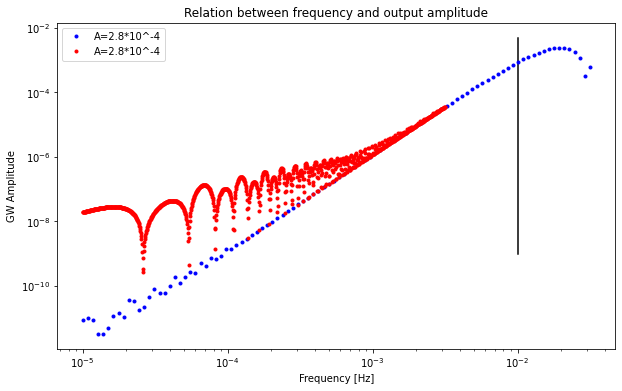

In [45]:
plt.figure(figsize=(10,6))
plt.plot([1e-2]*2,[1e-9,5e-3],c='black')
plt.loglog(freq_range,amp,linestyle='',marker='.',c='b',label= "A=2.8*10^-4")
plt.loglog(freq_range2,amp2,linestyle='',marker='.',c='r',label= "A=2.8*10^-4")
plt.xlabel("Frequency [Hz]")
plt.ylabel("GW Amplitude")
plt.legend()
plt.title("Relation between frequency and output amplitude")
plt.show()

# Differentiating two sine waves

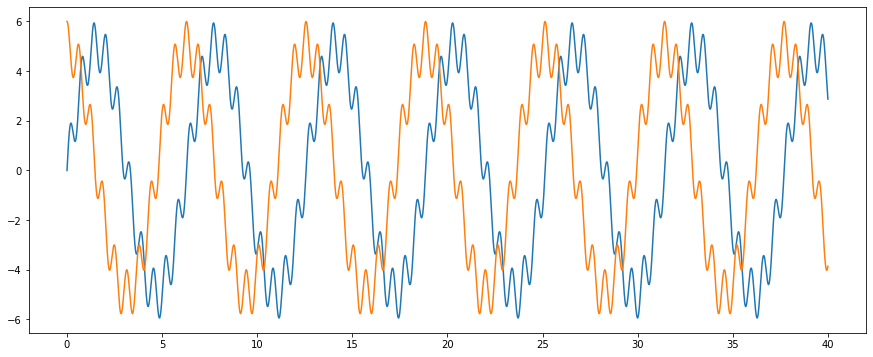

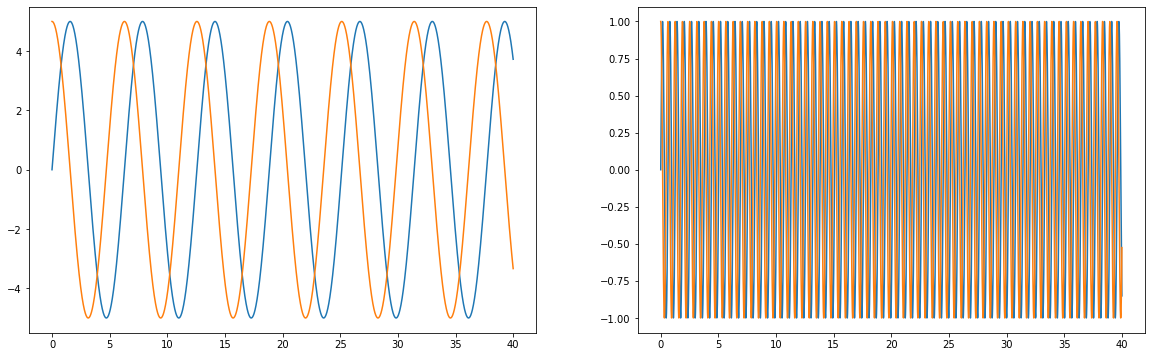

In [63]:
x = np.array(list(np.linspace(0,40,5000))*2).reshape(2,5000)
dx = x[0][1]-x[0][0]

def sine(x,A,phi0,f):
    return A*np.sin(f*(x.T) + phi0)

fact = 1/dx

Amps = [5,1]
offsets = np.array([0,0])#.2*np.pi])
freqs  = np.array([1,10])
plt.figure(figsize=(15,6))
# plt.plot(x[0],sine(x,Amps,offsets,freqs),c='black',alpha=.2)
plt.plot(x[0],np.sum(sine(x,Amps,offsets,freqs),axis=1))
plt.plot(x[0],np.sum(freqs*sine(x,Amps,offsets+(.5*np.pi),freqs)/freqs,axis=1))

# plt.plot((x[0][1:]+x[0][:-1])/2,fact*np.diff(np.sum(sine(x,Amps,offsets,freqs),axis=1)))
# plt.plot((x[0][1:]+x[0][:-1])/2,fact*np.diff(np.sum(sine(x,Amps,offsets,freqs),axis=1)))
plt.show()


# plt.figure(figsize=(15,6))
# # plt.plot(x[0],sine(x,Amps,offsets,freqs),c='black',alpha=.2)
# plt.plot(x[0],np.sum(sine(x,Amps,offsets,freqs),axis=1))
# for i in [0,1]:
#     plt.plot((x[0][1:]+x[0][:-1])/2,np.diff(np.sum(sine(x[0],Amps[i],offsets[i],freqs[i])/f,axis=1)))
# plt.show()


fig, axs = plt.subplots(1,2,figsize=(20,6))
for i in [0,1]:
    axs[i].plot(x[0],sine(x[i],Amps[i],offsets[i],freqs[i]))
    axs[i].plot(x[0],freqs[i]*sine(x[i],Amps[i],offsets[i]+(.5*np.pi),freqs[i])/freqs[i])
plt.show()

